<a href="https://colab.research.google.com/github/aliu-7/Molecular-Property-Optimization-Algorithms/blob/main/Alex_Liu_Generative_Models_with_Conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aliu-7/Molecular-Property-Optimization-Algorithms.git

Cloning into 'Molecular-Property-Optimization-Algorithms'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
!pip install rdkit-pypi
!pip install tensorflow
!pip install numpy pandas
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 9.8 MB/s eta 0:00:00


In [ ]:
# Load the ESOL dataset (direct source: https://github.com/deepchem/deepchem/blob/master/datasets/delaney-processed.csv)
url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
# Tokenize SMILES strings
data['tokenized_smiles'] = data['smiles'].apply(lambda x: list(x))

# Create a vocabulary of unique characters
vocab = sorted(set(''.join(data['smiles'].values)))
vocab.append(' ')  # Add a padding character
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Encode SMILES strings
max_length = max(data['tokenized_smiles'].apply(len))
data['encoded_smiles'] = data['tokenized_smiles'].apply(
    lambda x: [char_to_idx[char] for char in x] + [char_to_idx[' ']] * (max_length - len(x))
)

# Normalize solubility values
data['normalized_solubility'] = (data['measured log solubility in mols per litre'] - data['measured log solubility in mols per litre'].mean()) / data['measured log solubility in mols per litre'].std()

# Prepare input arrays
X = np.array(data['encoded_smiles'].tolist())
y = data['normalized_solubility'].values.reshape(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Set parameters
latent_dim = 50  # Dimensionality of the latent space
input_dim = X_train.shape[1]  # Length of the input sequences
vocab_size = len(vocab)  # Size of the vocabulary

# Encoder
smiles_input = layers.Input(shape=(input_dim,), name='SMILES_Input')
condition_input = layers.Input(shape=(1,), name='Condition_Input')

# Embed the SMILES input
x = layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=input_dim)(smiles_input)
x = layers.Concatenate()([x, layers.RepeatVector(input_dim)(condition_input)])
x = layers.LSTM(128, return_sequences=False)(x)

# Latent space
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='Latent_Input')
x = layers.Concatenate()([latent_inputs, condition_input])
x = layers.RepeatVector(input_dim)(x)
x = layers.LSTM(128, return_sequences=True)(x)
decoded = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(x)

# Define models
encoder = models.Model([smiles_input, condition_input], [z_mean, z_log_var, z], name='Encoder')
decoder = models.Model([latent_inputs, condition_input], decoded, name='Decoder')

# cVAE model
outputs = decoder([encoder([smiles_input, condition_input])[2], condition_input])
cvae = models.Model([smiles_input, condition_input], outputs, name='cVAE')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Custom VAE class with integrated loss
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        smiles_input, condition_input = inputs
        z_mean, z_log_var, z = self.encoder([smiles_input, condition_input])
        reconstructed = self.decoder([z, condition_input])

        # Reconstruction loss
        reconstruction_loss = tf.keras.losses.sparse_categorical_crossentropy(smiles_input, reconstructed)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)

        # Add the total loss
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)

        return reconstructed

# Compile the cVAE model
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer="adam")

# Train the model
cvae.fit([X_train, y_train], epochs=50, batch_size=32, validation_data=([X_test, y_test], None))

# code may take a bit of time to run as we are training 50 epochs

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 576ms/step - loss: 3.2345 - val_loss: 1.4668
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - loss: 1.3202 - val_loss: 1.0200
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - loss: 0.9922 - val_loss: 0.9294
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - loss: 0.8888 - val_loss: 0.8861
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - loss: 0.8954 - val_loss: 0.8556
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - loss: 0.8480 - val_loss: 0.8221
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - loss: 0.8242 - val_loss: 0.8294
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - loss: 0.8035 - val_loss: 0.8079
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - loss: 0.7825 - val_loss: 0.8009
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - loss: 0.7741 - val_loss: 0.7798
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - loss: 0.7920 - val_loss: 0.8064
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 22

In [ ]:
# Improved decoding using probability sampling instead of argmax
def decode_smiles_probabilistic(encoded_output, idx_to_char):
    smiles = ''
    for timestep in encoded_output:
        # Sample from the probability distribution to introduce diversity
        sampled_index = np.random.choice(len(timestep), p=timestep / np.sum(timestep))
        char = idx_to_char[sampled_index]
        if char != ' ':  # Skip padding
            smiles += char
    return smiles

# Generate diverse molecules based on desired solubility
def generate_molecules(desired_solubility, num_samples=10):
    generated_smiles_list = []

    for _ in range(num_samples):
        # Sample a random point from the latent space (standard normal distribution)
        latent_sample = np.random.normal(size=(1, 50))  # 50 is the latent_dim
        condition = np.array([[desired_solubility]])    # Desired solubility condition

        # Generate SMILES using the decoder
        generated_output = decoder.predict([latent_sample, condition])

        # Decode using probabilistic sampling
        generated_smiles = decode_smiles_probabilistic(generated_output[0], idx_to_char)
        generated_smiles_list.append(generated_smiles)

    return generated_smiles_list

# Evaluate and validate the generated molecules
def evaluate_molecules(smiles_list):
    valid_molecules = []
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:  # Check for chemical validity
                mol_weight = Descriptors.MolWt(mol)
                logP = Descriptors.MolLogP(mol)
                print(f" tValid SMILES: {smiles} | MolWt: {mol_weight:.2f}, LogP: {logP:.2f}")
                valid_molecules.append(smiles)
            else:
                print(f"Invalid SMILES: {smiles}")
        except:
            print(f"Error processing SMILES: {smiles}")
    return valid_molecules

# Optional: Visualize valid molecules
def visualize_molecules(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles)]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

# Example: Generate 10 molecules with high solubility (normalized around 0.9)
generated_molecules = generate_molecules(desired_solubility=0.9, num_samples=10)

# Display generated molecules
print("\nGenerated Molecules:")
for idx, smiles in enumerate(generated_molecules):
    print(f"Molecule {idx + 1}: {smiles}")

# Evaluate generated molecules for chemical validity
valid_molecules = evaluate_molecules(generated_molecules)

# Visualize valid molecules
if valid_molecules:
    display(visualize_molecules(valid_molecules))
else:
    print("No valid molecules generated.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Generated Molecules:
Molecule 1: csCNOccO()c(ccC))
Molecule 2: )(O=OcCc)n3((C)
Molecule 3: 6O(1C)c)cC1cO))
Molecule 4: /cCcCcC)l))cN=
Molecule 5: CccC(1(=c)CO=O)O
Molecule 6: IcCCC(c((C)C)1
Molecule 7: SCCc=)Nc1C1(cOcCO1O
Molecule 8: N)Cc)(cCCccOCN
Molecule 9: NC1)cCO(ccF
Molecule 10: ]C(nCcCccOcCC1C=2
Invalid SMILES: csCNOccO()c(ccC))
Invalid SMILES: )(O=OcCc)n3((C)
Invalid SMILES: 6O(1C)c)cC1cO))
Invalid SMILES: /cCcCcC)l))cN=
Invalid SMILES: CccC(1(=c)CO=O)O
Invalid SMILES: IcCCC(c((C)C)1
Invalid SMILES: SCCc=)Nc1C1(cOcCO1O
Invalid SMILES: N)Cc)(cCCccOCN
Invalid SMILES: NC1)cCO(ccF
Invalid SMILES: ]C(nCcCccOcCC

[02:32:18] SMILES Parse Error: syntax error while parsing: csCNOccO()c(ccC))
[02:32:18] SMILES Parse Error: Failed parsing SMILES 'csCNOccO()c(ccC))' for input: 'csCNOccO()c(ccC))'
[02:32:18] SMILES Parse Error: syntax error while parsing: )(O=OcCc)n3((C)
[02:32:18] SMILES Parse Error: Failed parsing SMILES ')(O=OcCc)n3((C)' for input: ')(O=OcCc)n3((C)'
[02:32:18] SMILES Parse Error: syntax error while parsing: 6O(1C)c)cC1cO))
[02:32:18] SMILES Parse Error: Failed parsing SMILES '6O(1C)c)cC1cO))' for input: '6O(1C)c)cC1cO))'
[02:32:18] SMILES Parse Error: syntax error while parsing: /cCcCcC)l))cN=
[02:32:18] SMILES Parse Error: Failed parsing SMILES '/cCcCcC)l))cN=' for input: '/cCcCcC)l))cN='
[02:32:18] SMILES Parse Error: syntax error while parsing: CccC(1(=c)CO=O)O
[02:32:18] SMILES Parse Error: Failed parsing SMILES 'CccC(1(=c)CO=O)O' for input: 'CccC(1(=c)CO=O)O'
[02:32:18] SMILES Parse Error: syntax error while parsing: IcCCC(c((C)C)1
[02:32:18] SMILES Parse Error: Failed parsing

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


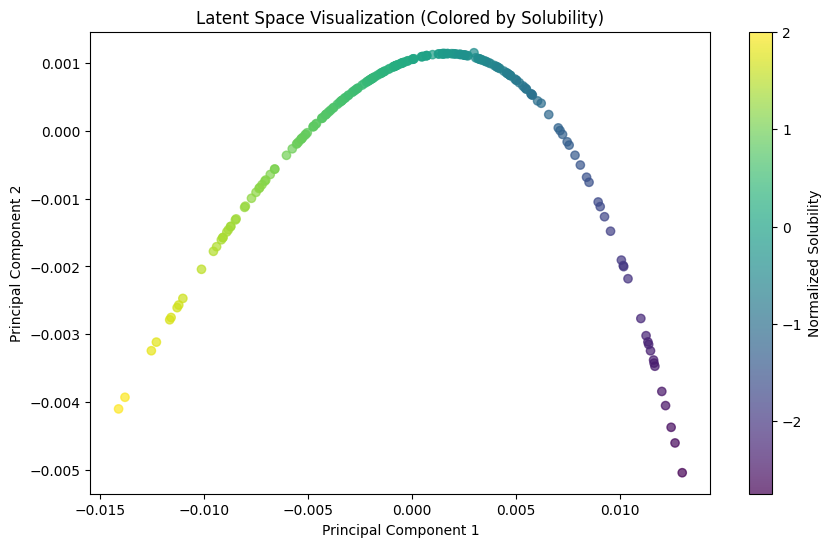

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Encode real molecules from the test set to visualize the latent space
z_mean, _, _ = encoder.predict([X_test, y_test])

# Reduce latent dimensions to 2D for visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Plot the latent space colored by solubility
plt.figure(figsize=(10, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test.flatten(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Normalized Solubility')
plt.title('Latent Space Visualization (Colored by Solubility)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Step 1: Inverse PCA to get the original latent vector
# Ensure 'pca' is the same PCA object used for dimensionality reduction
high_solubility_latent_2d = np.array([[ -0.01, 0.006 ]])  # Example coordinates from PCA plot
high_solubility_latent = pca.inverse_transform(high_solubility_latent_2d)  # Convert back to original latent space (50 dimensions)

# Step 2: Generate molecule
condition = np.array([[0.9]])  # High solubility condition

# Step 3: Decode
generated_output = decoder.predict([high_solubility_latent.reshape(1, -1), condition])
generated_smiles = decode_smiles_probabilistic(generated_output[0], idx_to_char)

# Step 4: Display the generated molecule
print(f"Generated molecule for high solubility region: {generated_smiles}")

# Generate molecules from both ends of the solubility spectrum
solubility_points = [(-0.01, 0.006), (0.015, 0.002)]  # Example: High and low solubility regions

for coords in solubility_points:
    latent_vector = pca.inverse_transform(np.array([coords]))
    condition = np.array([[0.9]])  # Adjust solubility condition as needed

    generated_output = decoder.predict([latent_vector.reshape(1, -1), condition])
    generated_smiles = decode_smiles_probabilistic(generated_output[0], idx_to_char)

    print(f"Generated molecule from latent space coordinates {coords}: {generated_smiles}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Generated molecule for high solubility region: SCc(n(C1=OC(
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Generated molecule from latent space coordinates (-0.01, 0.006): O)CCO)Nl)C)(11C)8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Generated molecule from latent space coordinates (0.015, 0.002): 3r1=112O)cC)c


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


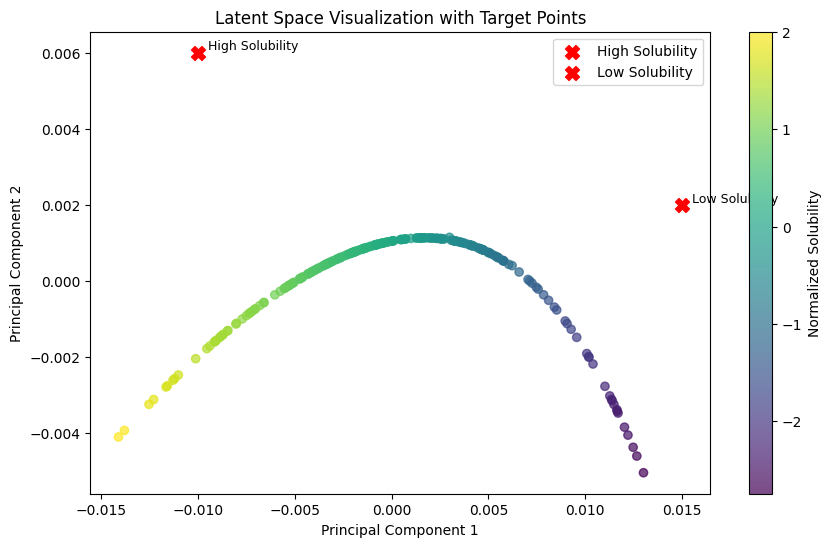

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
High Solubility Region → Generated SMILES: OC)1CNC=On(C)=OC1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Low Solubility Region → Generated SMILES: 1(=C(CC)2C))3


[02:36:04] SMILES Parse Error: extra close parentheses while parsing: OC)1CNC=On(C)=OC1
[02:36:04] SMILES Parse Error: Failed parsing SMILES 'OC)1CNC=On(C)=OC1' for input: 'OC)1CNC=On(C)=OC1'
[02:36:04] SMILES Parse Error: syntax error while parsing: 1(=C(CC)2C))3
[02:36:04] SMILES Parse Error: Failed parsing SMILES '1(=C(CC)2C))3' for input: '1(=C(CC)2C))3'


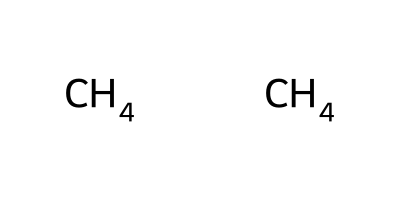

In [ ]:
# Step 1: Encode the test data to obtain the latent representations
z_mean, _, _ = encoder.predict([X_test, y_test])  # Encoder outputs for PCA
pca = PCA(n_components=2)                         # PCA for dimensionality reduction
z_pca = pca.fit_transform(z_mean)                 # Apply PCA

# Step 2: Define points of interest (for high and low solubility regions)
solubility_points = [(-0.01, 0.006), (0.015, 0.002)]  # Example points from the PCA plot
labels = ["High Solubility", "Low Solubility"]

# Step 3: Visualize the latent space with solubility gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test.flatten(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Normalized Solubility')

# Pinpoint the selected regions
for (x, y), label in zip(solubility_points, labels):
    plt.scatter(x, y, color='red', marker='X', s=100, label=label)
    plt.text(x + 0.0005, y, label, fontsize=9, verticalalignment='bottom')

plt.title('Latent Space Visualization with Target Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

# Step 4: Generate molecules from selected points
def decode_smiles_probabilistic(encoded_output, idx_to_char):
    smiles = ''
    for timestep in encoded_output:
        sampled_index = np.random.choice(len(timestep), p=timestep / np.sum(timestep))
        char = idx_to_char[sampled_index]
        if char != ' ':
            smiles += char
    return smiles

def generate_molecules_from_latent(pca_coords, condition_value=0.9):
    latent_vector = pca.inverse_transform(np.array([pca_coords]))
    condition = np.array([[condition_value]])  # Desired solubility condition
    generated_output = decoder.predict([latent_vector.reshape(1, -1), condition])
    generated_smiles = decode_smiles_probabilistic(generated_output[0], idx_to_char)
    return generated_smiles

# Step 5: Generate and visualize molecules
generated_molecules = []
for coords, label in zip(solubility_points, labels):
    smiles = generate_molecules_from_latent(coords, condition_value=0.9)
    generated_molecules.append((label, smiles))
    print(f"{label} Region → Generated SMILES: {smiles}")

# Step 6: Visualize generated molecules
def visualize_generated_molecules(smiles_list):
    mols = []
    for _, smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        mols.append(mol if mol else Chem.MolFromSmiles('C'))  # Placeholder for invalid SMILES
    return Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200))

# Display generated molecules
visualize_generated_molecules(generated_molecules)